#📈 Apple (AAPL) Historical Stock Dataset

Source: Yahoo Finance

Date Range: ~2015 → 2024 (you can extend/shorten as needed)

Frequency: Daily trading data

###Imports

In [26]:
!pip install yfinance

# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Finance data
import yfinance as yf


###Load the Dataset

In [45]:
df = pd.read_csv("aapl.csv", header=[0,1], index_col=0, parse_dates=True)

# Flatten multi-index column names
df.columns = [col[0] for col in df.columns]

df.head()


,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.261045,24.729268,23.821670,24.718172,212818400
2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000
2015-01-06,23.579798,23.839428,23.218089,23.641931,263188400
2015-01-07,23.910435,24.010292,23.677432,23.788385,160423600
2015-01-08,24.829134,24.886830,24.121251,24.238863,237458000


###EDA

In [46]:
df.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [47]:
df.duplicated().sum()

np.int64(0)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2515 non-null   float64
 1   High    2515 non-null   float64
 2   Low     2515 non-null   float64
 3   Open    2515 non-null   float64
 4   Volume  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


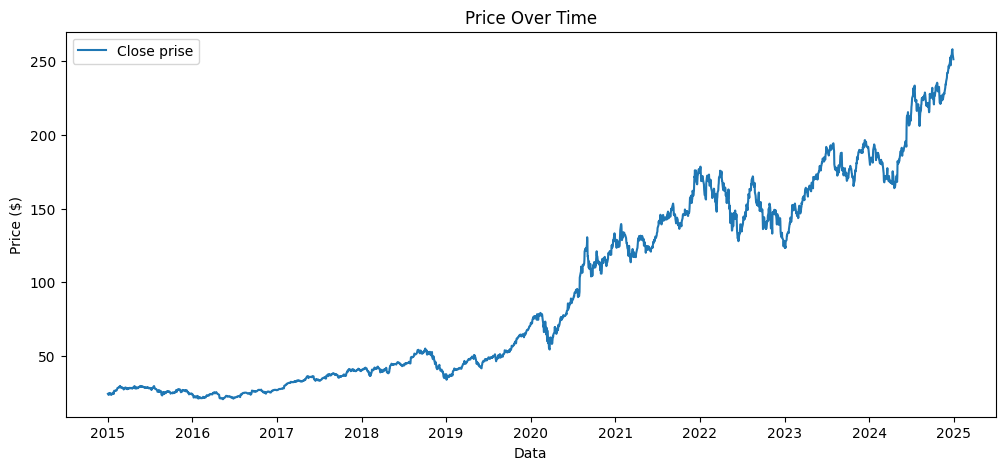

In [49]:
# Closing price trend

plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"], label="Close prise")
plt.title("Price Over Time")
plt.xlabel("Data")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

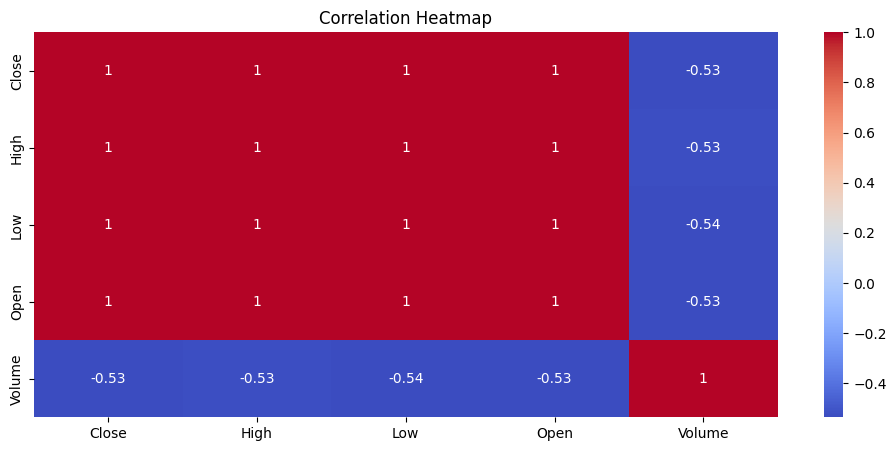

In [50]:
# Correlation heatmap

plt.figure(figsize=(12,5))
sns.heatmap(df.corr(numeric_only=True), annot=True,cmap = "coolwarm" )
plt.title("Correlation Heatmap")
plt.show()

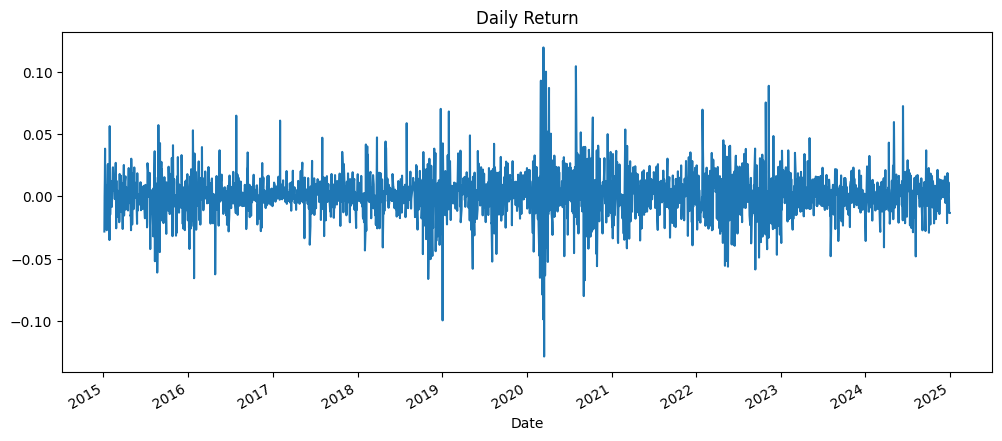

In [51]:
df["Return"] = df["Close"].pct_change()
df["Return"].plot(figsize=(12,5), title= "Daily Return")
plt.show()


###Feature engineering

In [52]:
df["Close"]

,Close
Date,
2015-01-02,24.261045
2015-01-05,23.577574
2015-01-06,23.579798
2015-01-07,23.910435
2015-01-08,24.829134
...,...
2024-12-23,254.367004
2024-12-24,257.286682
2024-12-26,258.103729


In [53]:
# avg trend in perticular day
# smooth trend line
df["MA5"] = df["Close"].rolling(5).mean()
df["MA10"] = df["Close"].rolling(10).mean()
df["MA520"] = df["Close"].rolling(20).mean()

In [54]:
# actual past value
# yesterday’s memory
df["Lag1"] = df["Close"].shift(1)
df["Lag2"] = df["Close"].shift(2)
df["Lag3"] = df["Close"].shift(3)

In [55]:
# Volatility (risk measure)
df["Volatility"] = df["High"] - df["Low"]

In [56]:
df["Return"] =df["Close"].pct_change()

In [57]:
df["UpDown"] = (df["Return"].shift(-1) > 0).astype(int)

In [58]:
df = df.dropna()

df.head()

,Close,High,Low,Open,Volume,Return,MA5,MA10,MA520,Lag1,Lag2,Lag3,Volatility,UpDown
Date,,,,,,,,,,,,,,
2015-01-30,25.998573,26.628787,25.929781,26.273737,334982000,-0.014635,25.457568,24.925657,24.552078,26.384701,25.588047,24.218882,0.699006,1
2015-02-02,26.324780,26.444609,25.758919,26.196075,250956400,0.012547,25.702996,25.206148,24.655265,25.998573,26.384701,25.588047,0.685691,1
2015-02-03,26.329220,26.426858,26.098437,26.295933,207662800,0.000169,26.125064,25.426501,24.792847,26.324780,25.998573,26.384701,0.328421,1
2015-02-04,26.531151,26.741963,26.253768,26.295930,280598800,0.007669,26.313685,25.648629,24.940415,26.329220,26.324780,25.998573,0.488196,1
2015-02-05,26.720518,26.785125,26.566798,26.738339,168984800,0.007138,26.380848,25.826451,25.080919,26.531151,26.329220,26.324780,0.218327,0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2496 entries, 2015-01-30 to 2024-12-30
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       2496 non-null   float64
 1   High        2496 non-null   float64
 2   Low         2496 non-null   float64
 3   Open        2496 non-null   float64
 4   Volume      2496 non-null   int64  
 5   Return      2496 non-null   float64
 6   MA5         2496 non-null   float64
 7   MA10        2496 non-null   float64
 8   MA520       2496 non-null   float64
 9   Lag1        2496 non-null   float64
 10  Lag2        2496 non-null   float64
 11  Lag3        2496 non-null   float64
 12  Volatility  2496 non-null   float64
 13  UpDown      2496 non-null   int64  
dtypes: float64(12), int64(2)
memory usage: 292.5 KB


###Prepare Data for Modeling

In [64]:
# For Regression (predicting price)

X_reg = df.drop(columns=["Close", "UpDown"])
y_reg = df["Close"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, shuffle=False
)

In [65]:
# For Classification (predicting Up/Down)

X_clf = df.drop(columns=["Close", "UpDown"])
y_clf = df["UpDown"]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, shuffle=False
)

### Regression Models

In [66]:
#1. Linear Regression
r = LinearRegression()
lr.fit(X_train_reg,y_train_reg)

LinearRegression()

In [67]:
y_pred_lr = lr.predict(X_test_reg)

In [68]:
# 2. Random Forest Regressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state= 42,

)

rf.fit(X_train_reg, y_train_reg)


RandomForestRegressor(n_estimators=300, random_state=42)

In [69]:
y_pred_rf = rf.predict(X_test_reg)

In [73]:
print("Linear Regression:")
print(" R²:", r2_score(y_test_reg, y_pred_lr))
print(" MAE:", mean_absolute_error(y_test_reg, y_pred_lr))
print(" RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)))


Linear Regression:
 R²: 0.9992922614140886
 MAE: 0.5865912827093566
 RMSE: 0.7418388341378507


In [75]:
print("\nRandom Forest Regressor:")
print(" R²:", r2_score(y_test_reg, y_pred_rf))
print(" MAE:", mean_absolute_error(y_test_reg, y_pred_rf))
print(" RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_rf)))


Random Forest Regressor:
 R²: -0.037127751429193445
 MAE: 18.11637137242635
 RMSE: 28.39809808513035


### Classification modeling

In [70]:
#  1. Logistic Regression

logR = LogisticRegression(
    max_iter=1000
)
logR.fit(X_train_clf, y_train_clf)

LogisticRegression(max_iter=1000)

In [71]:
y_pred_logR=logR.predict(X_test_clf)

In [72]:
y_proba_logR = logR.predict_proba(X_test_clf)[:,1]

In [76]:
# 2. Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)

y_pred_rf = rf_clf.predict(X_test_clf)
y_proba_rf = rf_clf.predict_proba(X_test_clf)[:,1]


In [80]:
print("Logistic Regression:")
print(" Accuracy:", accuracy_score(y_test_clf, y_pred_logR))
print(" Precision:", precision_score(y_test_clf, y_pred_logR))
print(" Recall:", recall_score(y_test_clf, y_pred_logR))
print(" F1:", f1_score(y_test_clf, y_pred_logR))
print(" ROC-AUC:", roc_auc_score(y_test_clf, y_proba_logR))


Logistic Regression:
 Accuracy: 0.562
 Precision: 0.562
 Recall: 1.0
 F1: 0.7195902688860435
 ROC-AUC: 0.5037618420838818


In [78]:
print("\nRandom Forest Classifier:")
print(" Accuracy:", accuracy_score(y_test_clf, y_pred_rf))
print(" Precision:", precision_score(y_test_clf, y_pred_rf))
print(" Recall:", recall_score(y_test_clf, y_pred_rf))
print(" F1:", f1_score(y_test_clf, y_pred_rf))
print(" ROC-AUC:", roc_auc_score(y_test_clf, y_proba_rf))


Random Forest Classifier:
 Accuracy: 0.45
 Precision: 0.546875
 Recall: 0.12455516014234876
 F1: 0.2028985507246377
 ROC-AUC: 0.5182323404670208


###Regression Results

In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Collect results
reg_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest Regressor"],
    "R2": [
        r2_score(y_test_reg, y_pred_lr),
        r2_score(y_test_reg, y_pred_rf)
    ],
    "MAE": [
        mean_absolute_error(y_test_reg, y_pred_lr),
        mean_absolute_error(y_test_reg, y_pred_rf)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
    ]
})

print("📊 Regression Results")
display(reg_results)


📊 Regression Results


,Model,R2,MAE,RMSE
0,Linear Regression,0.999292,0.586591,0.741839
1,Random Forest Regressor,-45.612975,188.307805,190.382286


###Classification Results

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Collect results
clf_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest Classifier"],
    "Accuracy": [
        accuracy_score(y_test_clf, y_pred_logR),
        accuracy_score(y_test_clf, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test_clf, y_pred_logR),
        precision_score(y_test_clf, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test_clf, y_pred_logR),
        recall_score(y_test_clf, y_pred_rf)
    ],
    "F1": [
        f1_score(y_test_clf, y_pred_logR),
        f1_score(y_test_clf, y_pred_rf)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test_clf, y_proba_logR),
        roc_auc_score(y_test_clf, y_proba_rf)
    ]
})

print("📊 Classification Results")
display(clf_results)

📊 Classification Results


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.562,0.562000,1.000000,0.719590,0.503762
1,Random Forest Classifier,0.450,0.546875,0.124555,0.202899,0.518232


# Summery

⚠️ This showed us: predicting today’s Close is too easy (cheaty) →


⚠️ Predicting daily up/down from just price history is hard (markets are noisy). Needs more engineered featur


